<a href="https://colab.research.google.com/github/brianmurii/Data-Structures-and-Algorithms/blob/main/Sentiment_Analysis_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
### ***Sentiment Analysis using a Convolutional Neural Network***


1. Importing all the required libraries



In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
# Setting class names(various sentiments), sequence lengths and classes

sentiment_classes = ['joy', 'fear', 'anger', 'sadness', 'neutral']
num_classes = 5
embedded_num_dims = 300
max_seq_len = 500

2. Data Preprocessing

In [ ]:
# Reading the dataset

data_train = pd.read_csv('data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data_test.csv', encoding='utf-8')
#UTF-8 takes the code point for a given Unicode character and translates it into a string of binary

X_train = data_train['Text'] #corresponding to column 'Text', same for the rest.
X_test = data_test['Text']

y_train = data_train['Emotion']
y_test = data_test['Emotion']

data = data_train.append(data_test, ignore_index=True) 
#columns in 'data_test' that are not in 'data_train' are added as new columns

In [ ]:
#Small view of the dataset
print(data['Emotion'].value_counts())
#Returns unique rows
data.head(10)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


In [ ]:
# cleaning text using nltk.word_tokenize
def clean_text(data):
    
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    data = word_tokenize(data)
    
    return data

In [ ]:
import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Updates internal vocabulary based on a list of texts;  creates the vocabulary index based on word frequency

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)
#Transforms each text in texts to a sequence of integers

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print(' The number of unique words are : {}'.format(len(index_of_words)))

 The number of unique words are : 12087


In [ ]:
#Ensuring all sequences have the same length
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
#Converting vectors to arrays
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
# Embedding Matrix

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # np.zeros returns a new array, filled with zeros
    with open(filepath, encoding = "utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embedded_num_dims)
embedd_matrix.shape

(12088, 300)

In [ ]:
embedd_layer = Embedding(vocab_size,
                         embedded_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
kernel_size = 2
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#creating a sequential model incrementally

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 conv1d (Conv1D)             (None, 499, 256)          153856    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,847,333
Trainable params: 220,933
Non-trainable params: 3,626,400
________________________________________

In [ ]:
batch_size = 256
epochs = 30

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/30
31/31 [==============================] - 75s 2s/step - loss: 1.4077 - accuracy: 0.4287 - val_loss: 1.1673 - val_accuracy: 0.6116
Epoch 2/30
31/31 [==============================] - 85s 3s/step - loss: 0.9010 - accuracy: 0.6969 - val_loss: 0.8121 - val_accuracy: 0.7038
Epoch 3/30
31/31 [==============================] - 69s 2s/step - loss: 0.6627 - accuracy: 0.7637 - val_loss: 0.7566 - val_accuracy: 0.7342
Epoch 4/30
31/31 [==============================] - 69s 2s/step - loss: 0.5518 - accuracy: 0.8148 - val_loss: 0.7160 - val_accuracy: 0.7489
Epoch 5/30
31/31 [==============================] - 67s 2s/step - loss: 0.4574 - accuracy: 0.8534 - val_loss: 0.6998 - val_accuracy: 0.7510
Epoch 6/30
31/31 [==============================] - 69s 2s/step - loss: 0.3880 - accuracy: 0.8801 - val_loss: 0.7045 - val_accuracy: 0.7507
Epoch 7/30
31/31 [==============================] - 69s 2s/step - loss: 0.3073 - accuracy: 0.9181 - val_loss: 0.6926 - val_accuracy: 0.7554
Epoch 8/30
31/31 [==

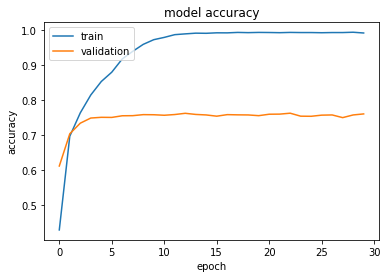

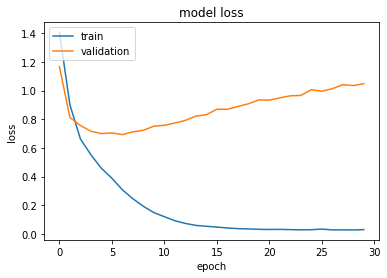

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [sentiment_classes[pred] for pred in predictions]
print("predictions:", predictions)
correct_predictions= np.nonzero(predictions == X_train_pad)[0]
incorrect_predictions = np.nonzero(predictions != X_train_pad)[0]
print(len(correct_predictions),"Classified correctly")
print(len(incorrect_predictions),"Classified incorrectly")

107/107 [==============================] - 11s 101ms/step
predictions: ['sadness', 'anger', 'anger', 'fear', 'sadness', 'neutral', 'anger', 'anger', 'neutral', 'sadness', 'neutral', 'neutral', 'fear', 'anger', 'anger', 'sadness', 'sadness', 'neutral', 'joy', 'anger', 'joy', 'fear', 'joy', 'anger', 'joy', 'fear', 'neutral', 'joy', 'anger', 'anger', 'joy', 'sadness', 'fear', 'anger', 'sadness', 'fear', 'fear', 'sadness', 'sadness', 'neutral', 'anger', 'fear', 'neutral', 'anger', 'neutral', 'joy', 'anger', 'anger', 'neutral', 'anger', 'anger', 'fear', 'joy', 'joy', 'anger', 'sadness', 'fear', 'joy', 'anger', 'neutral', 'neutral', 'fear', 'joy', 'anger', 'neutral', 'fear', 'neutral', 'joy', 'joy', 'joy', 'anger', 'sadness', 'sadness', 'joy', 'neutral', 'neutral', 'joy', 'fear', 'anger', 'sadness', 'joy', 'sadness', 'fear', 'sadness', 'fear', 'sadness', 'sadness', 'sadness', 'joy', 'anger', 'anger', 'anger', 'anger', 'neutral', 'joy', 'anger', 'anger', 'fear', 'fear', 'neutral', 'joy', 'ang

<ipython-input-19-88287c13b1a3>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  correct_predictions= np.nonzero(predictions == X_train_pad)[0]
<ipython-input-19-88287c13b1a3>:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  incorrect_predictions = np.nonzero(predictions != X_train_pad)[0]


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))


Accuracy: 76.07%

F1 Score: 76.07


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 76.07


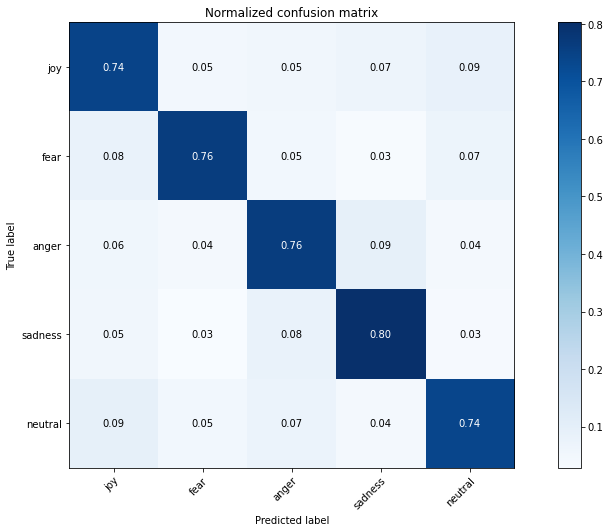

In [ ]:

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=sentiment_classes, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message:  {}\nPredicted: {}'.format(X_test[4], predictions[6]))
                                                                

Message:  My boyfriend didn't turn up after promising that he was coming.
Predicted: anger


In [ ]:
model.save('models/conv_net.h5')

In [ ]:
predictions2= model.predict(X_train_pad, verbose=0)[:15]
classes = np.argmax(predictions2, axis = 1)
print(classes)

[4 3 1 1 2 3 0 2 4 3 1 3 0 2 4]


In [ ]:
correct_predictions= np.nonzero(predictions == X_train_pad)[0]
incorrect_predictions = np.nonzero(predictions != X_train_pad)[0]
print(len(correct_predictions),"Classified correctly")
print(len(incorrect_predictions),"Classified incorrectly")


0 Classified correctly
1 Classified incorrectly


<ipython-input-26-84d289a2f9cd>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  correct_predictions= np.nonzero(predictions == X_train_pad)[0]
<ipython-input-26-84d289a2f9cd>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  incorrect_predictions = np.nonzero(predictions != X_train_pad)[0]


In [ ]:
import joblib

joblib.dump(model, "model.pkl")

['model.pkl']